In [29]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
import os
import tempfile
# Use system temp directory for caching
cache_dir = os.path.join(tempfile.gettempdir(), "f1_cache")
os.makedirs(cache_dir, exist_ok=True)

fastf1.Cache.enable_cache(cache_dir)

In [6]:
session_f1=fastf1.get_session(2024,"Japan", "R")
session_f1.load()

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No c

In [7]:
#Get laptime
laps_2024=session_f1.laps[['Driver', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']].copy()
laps_2024.dropna(inplace=True)

In [8]:
# Convert times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()


In [9]:
# Group by driver to get average sector times per driver
sector_times_2024 = laps_2024.groupby("Driver")[["Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)",'LapTime (s)']].mean().reset_index()
sector_times_2024

,Driver,Sector1Time (s),Sector2Time (s),Sector3Time (s),LapTime (s)
0,ALO,35.836200,43.152480,18.812900,97.801580
1,BOT,37.369380,43.882920,18.930600,100.182900
2,GAS,37.528200,44.069740,19.075720,100.673660
3,HAM,35.814000,43.281160,18.751840,97.847000
4,HUL,36.554531,43.537061,18.811857,98.903449
5,LEC,35.496140,43.240200,18.681140,97.417480
6,MAG,37.099260,43.905360,18.810420,99.815040
7,NOR,35.654020,43.148680,18.728900,97.531600
8,OCO,37.452320,43.958900,19.047620,100.458840
9,PER,35.454640,43.053560,18.698240,97.206440


In [10]:
# Manually input qualifying data for 2025 Japanese GP
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "LEC", "RUS", "HAM", "GAS", "ALO", "TSU", "SAI", "HUL", "OCO", "STR"],
    "QualifyingTime (s)": [86.983, 86.995, 87.027, 87.299, 87.318, 87.610, 87.822, 87.897, 88.000, 87.836, 88.570, 88.696, 89.271]
})


In [11]:
# Add wet performance factor from script
driver_wet_performance = {
    "VER": 0.975196, 
    "HAM": 0.976464,  
    "LEC": 0.975862,  
    "NOR": 0.978179,  
    "ALO": 0.972655,  
    "RUS": 0.968678,  
    "SAI": 0.978754,  
    "TSU": 0.996338,  
    "OCO": 0.981810,  
    "GAS": 0.978832,  
    "STR": 0.979857   
}
qualifying_2025["WetPerformanceFactor"] = qualifying_2025["Driver"].map(driver_wet_performance)

In [12]:
# Weather Data
API_KEY = "d2585e28290357a9db05c428cdb49ae9"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=34.8823&lon=136.5845&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()
print(weather_data)


{'cod': '200', 'message': 0, 'cnt': 40, 'list': [{'dt': 1755388800, 'main': {'temp': 28.73, 'feels_like': 34, 'temp_min': 28.73, 'temp_max': 30.32, 'pressure': 1015, 'sea_level': 1015, 'grnd_level': 1007, 'humidity': 80, 'temp_kf': -1.59}, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10d'}], 'clouds': {'all': 68}, 'wind': {'speed': 1.54, 'deg': 7, 'gust': 2.31}, 'visibility': 10000, 'pop': 0.49, 'rain': {'3h': 0.21}, 'sys': {'pod': 'd'}, 'dt_txt': '2025-08-17 00:00:00'}, {'dt': 1755399600, 'main': {'temp': 30.49, 'feels_like': 36.53, 'temp_min': 30.49, 'temp_max': 31.76, 'pressure': 1014, 'sea_level': 1014, 'grnd_level': 1006, 'humidity': 71, 'temp_kf': -1.27}, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04d'}], 'clouds': {'all': 65}, 'wind': {'speed': 2.17, 'deg': 140, 'gust': 2.72}, 'visibility': 10000, 'pop': 0, 'sys': {'pod': 'd'}, 'dt_txt': '2025-08-17 03:00:00'}, {'dt': 1755410400, 'main': {'temp': 32.31, 'fe

In [13]:
# Extract the relevant weather data for the race (Sunday at 2pm local time)
forecast_time = "2025-04-05 14:00:00"
forecast_data = None
for forecast in weather_data["list"]:
    if forecast["dt_txt"] == forecast_time:
        forecast_data = forecast
        break

if forecast_data:
    rain_probability = forecast_data["pop"]
    temperature = forecast_data["main"]["temp"]  
else:
    rain_probability = 0 
    temperature = 20 

In [14]:
# Merge qualifying data with sector times data 
merged_data = qualifying_2025.merge(sector_times_2024, left_on="Driver", right_on="Driver", how="left")


In [15]:
# Create weather features for the model
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature


In [16]:
# Define feature set (Qualifying + Sector Times + Weather + Wet Performance Factor)
X = merged_data[["QualifyingTime (s)", "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)", "WetPerformanceFactor", "RainProbability", "Temperature"]].fillna(0)

In [17]:
# Use average lap time as the target
y = merged_data.merge(laps_2024.groupby("Driver")["LapTime"].mean(), left_on="Driver", right_index=True)["LapTime (s)"]


In [19]:
print(merged_data.columns.tolist())


['Driver', 'QualifyingTime (s)', 'WetPerformanceFactor', 'Sector1Time (s)', 'Sector2Time (s)', 'Sector3Time (s)', 'LapTime (s)', 'RainProbability', 'Temperature']


In [20]:
merged_data["SectorSum (s)"] = (
    merged_data["Sector1Time (s)"].astype(float)
    + merged_data["Sector2Time (s)"].astype(float)
    + merged_data["Sector3Time (s)"].astype(float)
)


In [21]:
drivers = merged_data["Driver"].tolist()  # Use Driver instead of DriverCode
qual_times = merged_data["QualifyingTime (s)"].astype(float)
sector_sums = merged_data["SectorSum (s)"].astype(float)


In [22]:
# Train Gradient Boosting Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=38)
model.fit(X_train, y_train)



GradientBoostingRegressor(n_estimators=200, random_state=38)

In [23]:
# Predict race times using 2025 qualifying and sector data
predicted_race_times = model.predict(X)
qualifying_2025["PredictedRaceTime (s)"] = predicted_race_times
qualifying_2025 = qualifying_2025.sort_values(by="PredictedRaceTime (s)")


In [24]:
print("\n🏁 Predicted 2025 Japanese GP Winner🏁\n")
print(qualifying_2025[["Driver", "PredictedRaceTime (s)"]])


🏁 Predicted 2025 Japanese GP Winner🏁

   Driver  PredictedRaceTime (s)
0     VER              96.975560
3     LEC              97.417480
1     NOR              97.531600
4     RUS              97.766740
5     HAM              97.847000
2     PIA              97.849040
9     SAI              97.873861
7     ALO              97.917323
10    HUL              98.523858
8     TSU              98.865694
12    STR              99.019673
11    OCO             100.458840
6     GAS             100.673660


In [25]:
# Define feature set (Qualifying + Sector Times)
X = merged_data[["QualifyingTime (s)", "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)"]].fillna(0)
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reset_index()["LapTime (s)"]


In [26]:
# Evaluate 
y_pred = model.predict(X_test)
print(f"\n🔍 Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")


🔍 Model Error (MAE): 0.34 seconds


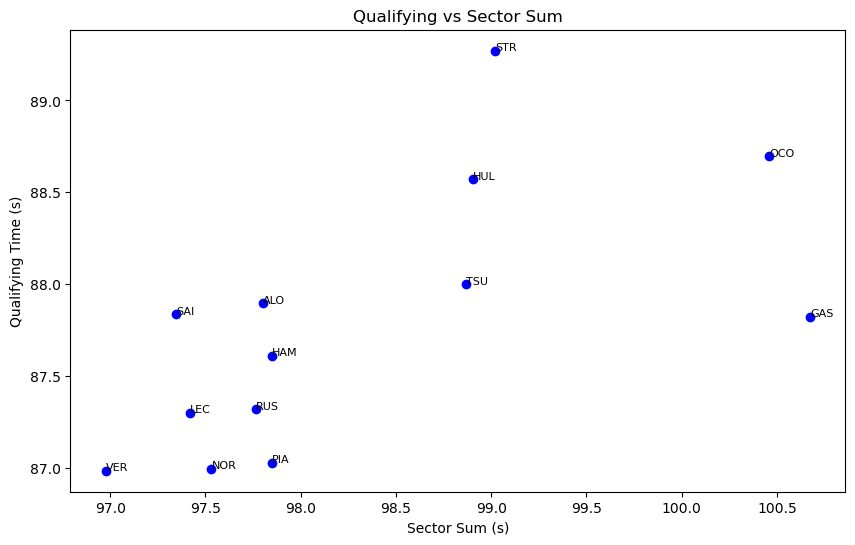

In [27]:
#Qualifying vs Sector Sum Comparison
plt.figure(figsize=(10,6))
plt.scatter(merged_data["SectorSum (s)"], merged_data["QualifyingTime (s)"], color="blue")
for i, d in merged_data.iterrows():
    plt.text(d["SectorSum (s)"], d["QualifyingTime (s)"], d["Driver"], fontsize=8)
plt.xlabel("Sector Sum (s)")
plt.ylabel("Qualifying Time (s)")
plt.title("Qualifying vs Sector Sum")
plt.show()

/var/folders/q4/r82zndsd4y35n76xr9d24qh00000gn/T/ipykernel_58965/3448600425.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Driver", y="DeltaToFastest", data=merged_data, palette="coolwarm")


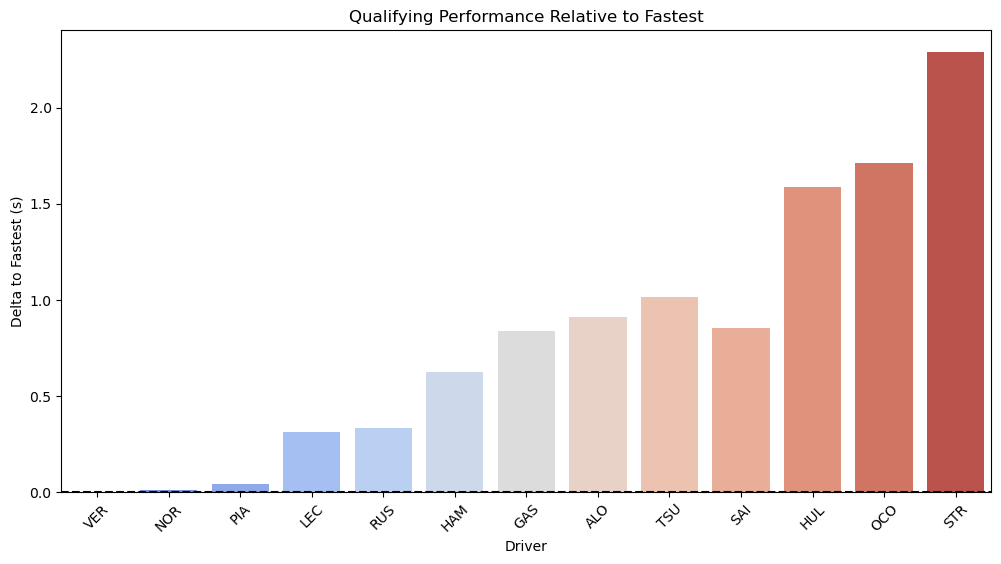

In [30]:
#Delta Bar Chart (Improved)
merged_data["DeltaToFastest"] = merged_data["QualifyingTime (s)"] - merged_data["QualifyingTime (s)"].min()

plt.figure(figsize=(12,6))
sns.barplot(x="Driver", y="DeltaToFastest", data=merged_data, palette="coolwarm")
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("Delta to Fastest (s)")
plt.title("Qualifying Performance Relative to Fastest")
plt.xticks(rotation=45)
plt.show()


In [35]:
#Race Pace Prediction
plt.figure(figsize=(12,6))
plt.bar(merged_data["Driver"], merged_data["PredictedRacePace"], color="green")
plt.ylabel("Predicted Race Lap Time (s)")
plt.title("Predicted Race Pace (Weather + Wet Factors)")
plt.xticks(rotation=45)
plt.show()


KeyError: 'PredictedRacePace'

<Figure size 1200x600 with 0 Axes>

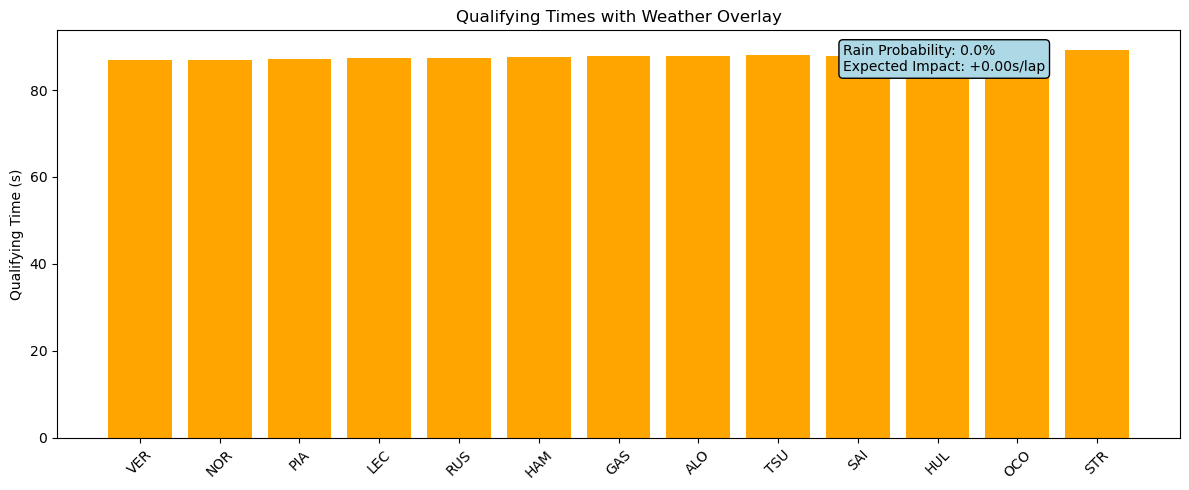

In [33]:
rain_prob = merged_data["RainProbability"].mean()
impact = rain_prob * 0.2  # adjust factor as needed

plt.figure(figsize=(12,5))
plt.bar(merged_data["Driver"], merged_data["QualifyingTime (s)"], color="orange")
plt.xticks(rotation=45)
plt.ylabel("Qualifying Time (s)")
plt.title("Qualifying Times with Weather Overlay")

# Weather annotation
plt.annotate(
    f"Rain Probability: {rain_prob:.1f}%\nExpected Impact: +{impact:.2f}s/lap",
    xy=(0.7, 0.9), xycoords="axes fraction",
    bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="black", lw=1),
    fontsize=10
)

plt.tight_layout()
plt.show()
